In [180]:
from sheap.spectra_readers import parallel_reader 
from sheap.MainSheap import Sheapectral 
from sheap.RegionHandler.RegionBuilder import RegionBuilder
from sheap.RegionHandler.RegionFitting import RegionFitting
from sheap.Plotting.SheapPlot import SheapPlot
from sheap.Posterior.ParameterEstimation import ParameterEstimation


In [2]:
import jax 
from jax import jit 
import jax.numpy as jnp
import glob 
import os 
import pandas as pd 
import matplotlib.pyplot as plt 
from paths_func import cross_pandas_spectra
jax.config.update("jax_enable_x64", True)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
path_dr16 = "/home/favila/smbh_mass/dr16"
path_dr16 = "/home/felipe/work/SMBH_estimation/dr16"

In [5]:
#dr16/subsample_07_03_25.csv

In [6]:
file_paths,objs_panda  = cross_pandas_spectra(path_dr16,"sdss_fits","dr16_pandas.csv")
objs_panda_sort =objs_panda
#file_paths,objs_panda = cross_pandas_spectra(path_dr16,"new_sub_sample_sdss_fits","subsample_07_03_25.csv")
objs_panda_sort = objs_panda.sort_values("SN_MEDIAN_ALL",ascending=False)[:1500][:100]
objs_panda_sort = objs_panda_sort.reset_index(drop=True)

You cross match found 7644


In [322]:
ja = pd.read_csv(path_dr16 +"/dr16_pandas.csv")

In [357]:
objs_panda_sort.fit_path.values[0]

'/home/felipe/work/SMBH_estimation/dr16/sdss_fits/8543-57542-0855.fits'

In [7]:
from astropy.io import fits 

In [358]:
aja = fits.open('/home/felipe/work/SMBH_estimation/dr16/sdss_fits/8543-57542-0855.fits')

In [360]:
aja[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TELESCOP= 'SDSS 2.5-M'         / Sloan Digital Sky Survey                       
V_BOSS  = 'v4_0    '           / Active version of the BOSS ICC                 
FLAVOR  = 'science '           / exposure type, SDSS spectro style              
MJD     =                57542 / APO fMJD day at start of exposure              
MJDLIST = '57541 57542'        /                                                
V_GUIDER= 'v3_4    '           / version of the current guiderActor             
V_SOP   = 'v3_8_1  '           / version of the current sopActor                
NAME    = '8543-57540-01'      / The name of the currently loaded plate         
PLATEID =                 85

In [ ]:
#erg/cm^2/s/Ang

In [37]:
#objs_panda_sort[objs_panda_sort.SDSS_NAME == "124813.82+362423.6"].fit_path.values

In [8]:
coords,spectra_reshaped,_ = parallel_reader(objs_panda_sort.fit_path.values)
coords = jnp.array(coords)
spectra_reshaped = jnp.array(spectra_reshaped)

/home/felipe/work/MyPackages/sheap/sheap/spectra_readers.py:14: RuntimeWarning: divide by zero encountered in divide
  aD = np.array([10**hdul[1].data[key] if key == "loglam" else (float(hdul[0].header["BUNIT"].split(" ")[0]) / np.sqrt(hdul[1].data[key]) if key == "ivar" else hdul[1].data[key]*float(hdul[0].header["BUNIT"].split(" ")[0])) for key in ["loglam", "flux", "ivar"]])
/home/felipe/work/MyPackages/sheap/sheap/spectra_readers.py:14: RuntimeWarning: divide by zero encountered in divide
  aD = np.array([10**hdul[1].data[key] if key == "loglam" else (float(hdul[0].header["BUNIT"].split(" ")[0]) / np.sqrt(hdul[1].data[key]) if key == "ivar" else hdul[1].data[key]*float(hdul[0].header["BUNIT"].split(" ")[0])) for key in ["loglam", "flux", "ivar"]])
/home/felipe/work/MyPackages/sheap/sheap/spectra_readers.py:14: RuntimeWarning: divide by zero encountered in divide
  aD = np.array([10**hdul[1].data[key] if key == "loglam" else (float(hdul[0].header["BUNIT"].split(" ")[0]) / np.sqrt(hd

In [39]:
objs_panda_sort

,SDSS_NAME,Z_DR16Q,FHOST_5100,Z_FIT,PLATE,MJD,FIBERID,RA,DEC,EBV,IF_BOSS_SDSS,SN_MEDIAN_ALL,dr_name,fit_path
0,162633.92+480230.1,0.242327,0.000000,0.242327,8543,57542,855,246.641373,48.041712,0.012281,BOSS,32.942696,8543-57542-0855,/home/felipe/work/SMBH_estimation/dr16/sdss_fi...
1,121340.21+255156.5,0.696200,0.761199,0.696200,2657,54502,371,183.417563,25.865722,0.019595,SDSS,32.439930,2657-54502-0371,/home/felipe/work/SMBH_estimation/dr16/sdss_fi...
2,222549.42+194916.3,0.252046,0.490743,0.252046,7582,56960,368,336.455942,19.821195,0.043004,BOSS,29.003782,7582-56960-0368,/home/felipe/work/SMBH_estimation/dr16/sdss_fi...
3,113635.95+063113.6,0.527984,0.000000,0.527984,1619,53084,60,174.149804,6.520456,0.033231,SDSS,28.826843,1619-53084-0060,/home/felipe/work/SMBH_estimation/dr16/sdss_fi...
4,000051.33+075147.8,0.365471,0.534657,0.365471,11277,58450,252,0.213914,7.863293,0.042086,BOSS,27.691708,11277-58450-0252,/home/felipe/work/SMBH_estimation/dr16/sdss_fi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,073648.65+321437.1,0.338371,0.916682,0.338371,541,51959,150,114.202738,32.243652,0.036671,SDSS,15.842133,0541-51959-0150,/home/felipe/work/SMBH_estimation/dr16/sdss_fi...
96,110024.94+535903.3,0.625275,0.000000,0.625275,8172,57423,101,165.103952,53.984252,0.007560,BOSS,15.757833,8172-57423-0101,/home/felipe/work/SMBH_estimation/dr16/sdss_fi...
97,010604.64+013907.7,0.781000,0.000000,0.781000,4311,55506,178,16.519372,1.652144,0.021459,BOSS,15.659475,4311-55506-0178,/home/felipe/work/SMBH_estimation/dr16/sdss_fi...
98,025735.33-001631.3,0.362460,0.000000,0.362460,9370,58056,161,44.397209,-0.275375,0.065708,BOSS,15.645144,9370-58056-0161,/home/felipe/work/SMBH_estimation/dr16/sdss_fi...


In [84]:
test_clase = Sheapectral(spectra_reshaped,z=objs_panda_sort["Z_DR16Q"].values,coords = coords)
z_s=test_clase.z
#norm_factor=10**test_clase.spectra_exp
exp_factor = test_clase.spectra_exp
Spectra = test_clase.spectra

In [ ]:
region = RegionBuilder(4400, 5600)
region.make_region(verbose=True,Fe_regions=['Fe_uv',"FeII_IZw1","feII_forbidden","FeII_coronal"],force_linear=True
                   ,n_broad = 2,n_narrow =1,narrow_plus=False,add_out_flow=True,tied_narrow_to="OIIIc",template_mode_Fe=False)
Hbeta_class = RegionFitting(region.to_complex(add_free=True))

We assume a local linear continuum


- template with 1000 as initial it is ok 
- gaussian sum?

In [86]:
#Hbeta_class = RegionFitting("Halpha")
Hbeta_class(Spectra,exp_factor=exp_factor,num_steps=1000,re_normalize=True)

Runing: tied_params_step_1
learning_rate: 0.1
optimizer: adabelief
num_steps: 1000
Runing: tied_params_step_2
We assume a local linear continuum
learning_rate: 0.01
optimizer: adabelief
num_steps: 1000


In [526]:
Hbeta_class.tied_params

[['amplitude_Halpha_1_narrow', 'amplitude_NIIb_1_narrow', '*3.'],
 ['amplitude_NIIa_1_narrow', 'amplitude_NIIb_1_narrow', '*0.3'],
 ['center_SIIb_1_narrow', 'center_NIIb_1_narrow'],
 ['center_OIb_1_narrow', 'center_NIIb_1_narrow'],
 ['center_OIa_1_narrow', 'center_NIIb_1_narrow'],
 ['center_SIIa_1_narrow', 'center_NIIb_1_narrow'],
 ['center_NIIa_1_narrow', 'center_NIIb_1_narrow'],
 ['width_NIIa_1_narrow', 'width_NIIb_1_narrow'],
 ['width_SIIb_1_narrow', 'width_NIIb_1_narrow'],
 ['width_SIIa_1_narrow', 'width_NIIb_1_narrow'],
 ['width_OIa_1_narrow', 'width_NIIb_1_narrow'],
 ['width_OIb_1_narrow', 'width_NIIb_1_narrow']]

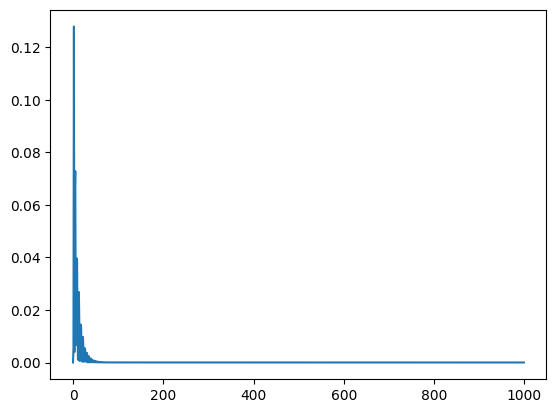

In [509]:
plt.plot(np.array(Hbeta_class.loss).T[0])

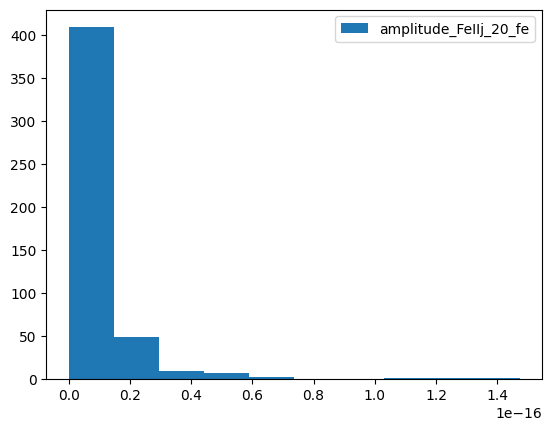

In [254]:
n_param = 27
plt.hist(Hbeta_class.params[:,n_param],label = list(Hbeta_class.params_dict.keys())[n_param] )
plt.legend()

In [255]:
# ii = pd.DataFrame(Hbeta_class.initial_params)

In [256]:
region_panda[region_panda["kind"]=="Fe"]

,center,line_name,kind,component,amplitude,how,profile


In [77]:
cc = Hbeta_class.panda_params
jnp.subtract(*cc[[c for c in cc.columns.values if "NII" in c and "center" in c]].values.T)

Array([35.41,   nan, 35.41, 35.41, 35.41, 35.41, 35.41, 35.41, 35.41,
       35.41, 35.41, 35.41, 35.41, 35.41, 35.41, 35.41, 35.41, 35.41,
       35.41, 35.41, 35.41, 35.41, 35.41, 35.41, 35.41, 35.41, 35.41,
       35.41, 35.41, 35.41,   nan, 35.41, 35.41, 35.41,   nan, 35.41,
       35.41, 35.41,   nan, 35.41, 35.41, 35.41, 35.41, 35.41, 35.41,
         nan,   nan, 35.41, 35.41, 35.41, 35.41, 35.41, 35.41, 35.41,
       35.41, 35.41, 35.41,   nan, 35.41, 35.41, 35.41,   nan, 35.41,
       35.41, 35.41, 35.41,   nan, 35.41, 35.41,   nan, 35.41, 35.41,
       35.41, 35.41, 35.41, 35.41, 35.41, 35.41,   nan,   nan, 35.41,
       35.41, 35.41, 35.41,   nan, 35.41,   nan, 35.41, 35.41, 35.41,
         nan, 35.41, 35.41, 35.41,   nan, 35.41, 35.41, 35.41, 35.41,
       35.41], dtype=float64)

In [291]:
Hbeta_class.mask_region

Array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

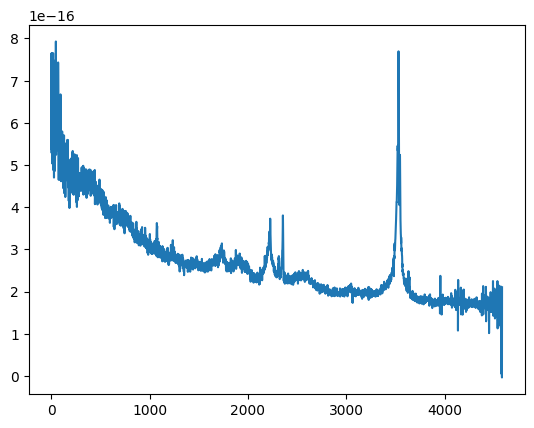

In [353]:
plt.plot(spectra_reshaped[0,1,:])

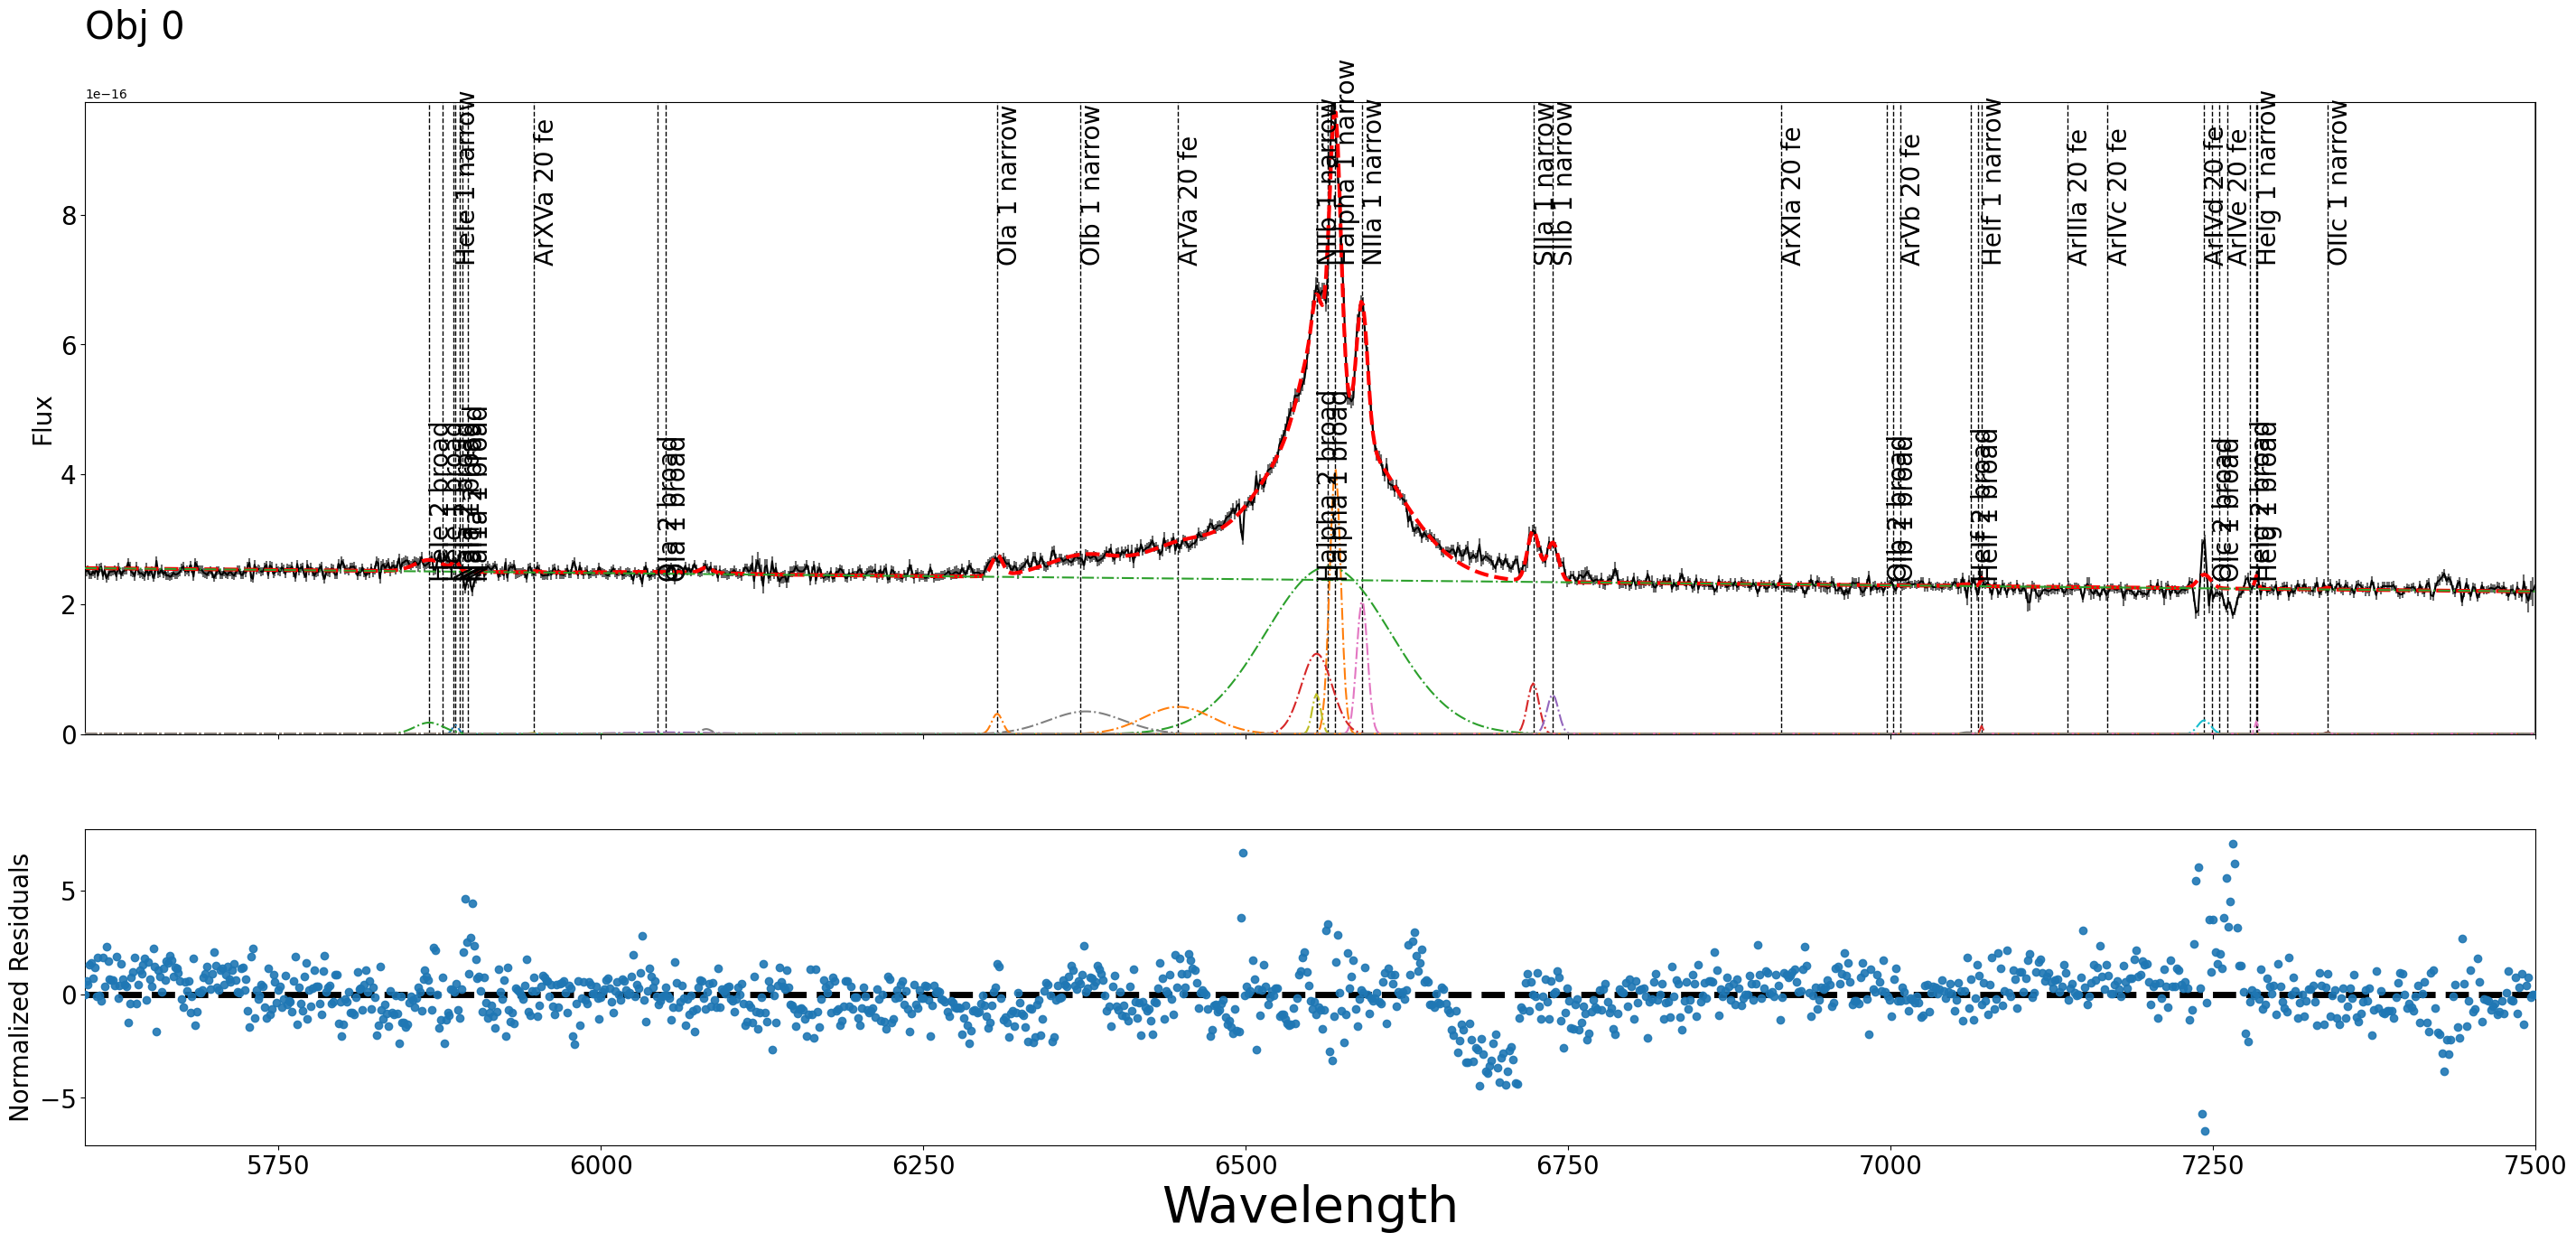

In [365]:
n = 0
region_plot = SheapPlot(Hbeta_class)
region_plot.plot(n,xlim=[5600, 7500],add_name=True)#207

In [29]:
# from typing import Any, Tuple, Mapping

# def dict_to_key(d: Mapping[Any, Any]) -> Tuple[Tuple[Any,Any], ...]:
#     """Convert a dict into a hashable, sorted tuple-of-items."""
#     return tuple(sorted(d.items()))

# def key_to_dict(key: Tuple[Tuple[Any,Any], ...]) -> dict:
#     """Convert back the tuple-of-items into a dict."""
#     return dict(key)

In [345]:
params = ParameterEstimation(Hbeta_class, z=test_clase.z)

In [390]:
params.L5100()[0]

Array([0.], dtype=float64)

In [348]:
params.Lbool()

(100,)


Array([ 6.07099778e+43,  0.00000000e+00,  6.42184572e+43,  9.52644722e+43,
        1.10447231e+44,  1.02933713e+43,  1.57411883e+44,  3.86354966e+43,
        1.13610289e+44,  1.17985777e+44,  6.92692592e+43,  9.54087233e+43,
        5.68900097e+43,  2.74696523e+43,  1.53490811e+43,  4.65729008e+43,
        8.79871747e+43,  6.04738337e+43,  3.11433962e+43,  1.02316808e+44,
        1.53146356e+43,  8.04551157e+43,  8.48744603e+43,  1.48774872e+43,
        6.69058632e+43,  2.83301139e+43,  1.26257919e+43,  6.27804388e+43,
        7.82843485e+43,  5.17596186e+43,  0.00000000e+00,  7.97816562e+43,
        6.02291787e+43, -6.46427181e+42,  0.00000000e+00,  5.01484193e+43,
        8.38923286e+42,  4.28895612e+43,  0.00000000e+00,  6.02989057e+43,
        1.21030364e+43,  3.46276299e+43,  4.10099604e+43,  2.93762753e+43,
        2.50140148e+43,  0.00000000e+00,  0.00000000e+00,  1.65182104e+43,
        6.20732171e+43,  2.81788558e+43,  1.17295831e+44,  7.25470604e+43,
        5.01984162e+43,  

In [ ]:
from jax.scipy.integrate import trapezoid
baselines_s = jnp.where(params.RegionClass.mask_region,0,params.baselines)
x = jnp.where(params.RegionClass.mask_region,0,params.RegionClass.region_to_fit[:,0,:])
flux = trapezoid(baselines_s, x=x, axis=1)
#flux = jsp.integrate.trapezoid(jnp.where(mask_fit_g,0,1-(full_model)/Baselines),x=jnp.where(mask_fit_g,0,Spectra[:,0,:]),axis=1)
#return 4. * jnp.pi * self.d**2 * flux 

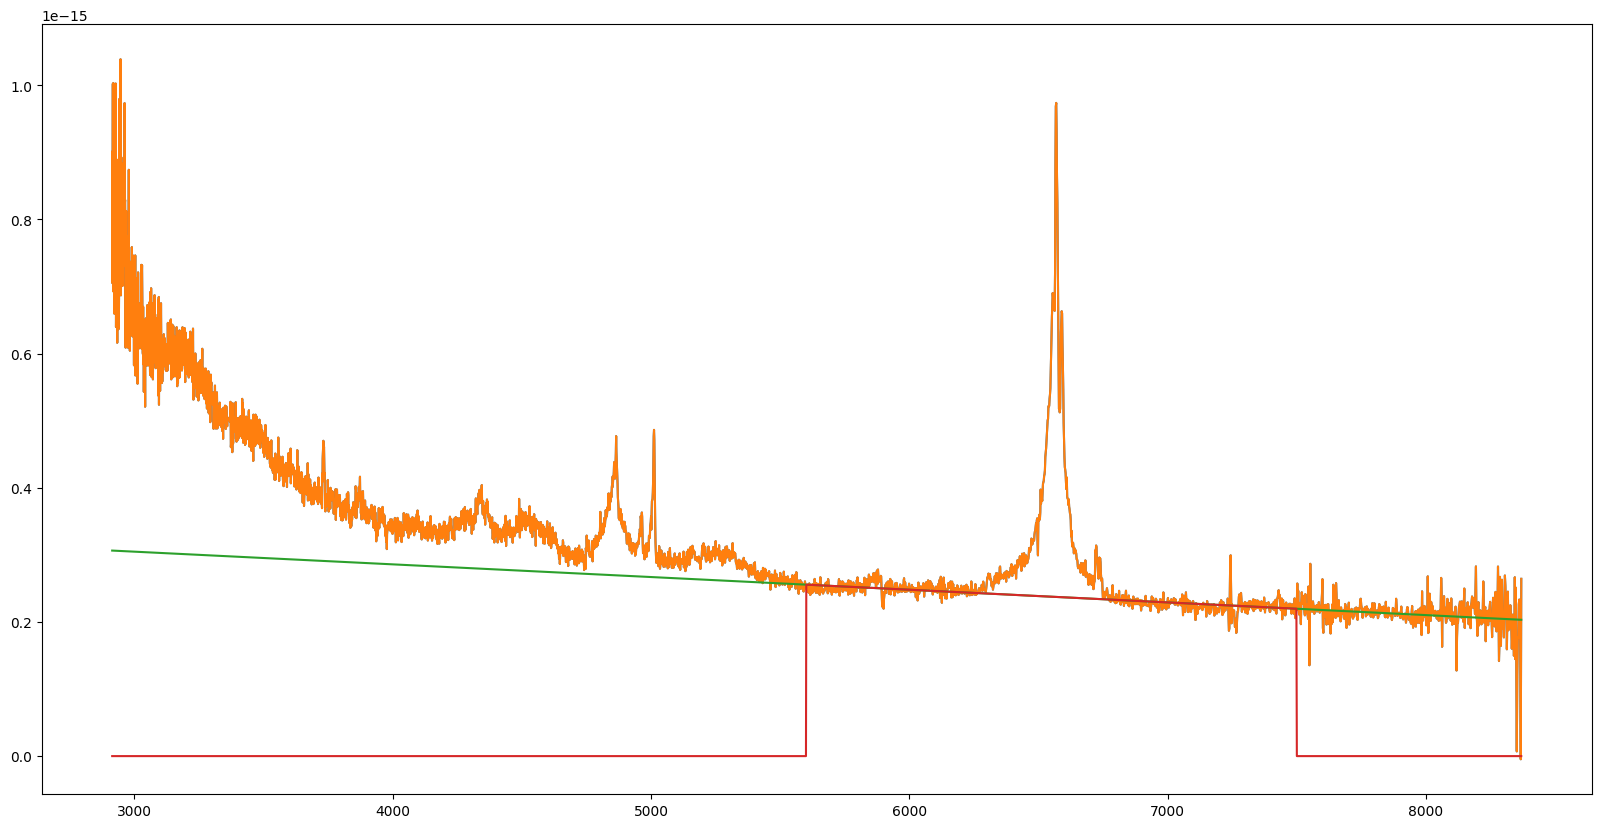

In [382]:
plt.figure(figsize=(20,10))
plt.plot(test_clase.spectra[0,0,:],test_clase.spectra[0,1,:]*10**(-exp_factor[0]))
plt.plot(params.RegionClass.region_to_fit[0,0,:],params.RegionClass.region_to_fit[0,1,:])
plt.plot(params.RegionClass.region_to_fit[0,0,:],params.baselines[0])
plt.plot(params.RegionClass.region_to_fit[0,0,:],baselines_s[0])


In [387]:
 4. * jnp.pi *flux[0]* params.d[0]**2

Array(6.07099778e+43, dtype=float64)

In [170]:
from jax import vmap 
from sheap.tools.others import vmap_get_EQW_mask
profile_index_list = Hbeta_class.profile_index_list
x_axis = Hbeta_class.region_to_fit[:,0,:]
mask = Hbeta_class.mask_region
#this is based on the idea about the continium is the last profile added to the code maybe could be a good idea have the exacto position of it 
min_,max_ = profile_index_list[-1]
values = Hbeta_class.params[:,min_:max_]
profile_func = vmap(Hbeta_class.profile_function_list[-1],in_axes=(0, 0))
baselines = profile_func(Hbeta_class.region_to_fit[:,0,:],values)
EW = []
for i,profile in enumerate(Hbeta_class.profile_list):
    profile_func = vmap(Hbeta_class.profile_function_list[i],in_axes=(0, 0))#maybe ask is the previous one is other proflie?
    min_,max_ = profile_index_list[i]
    values = Hbeta_class.params[:,min_:max_]
    if profile != "linear" and "Fe" not in profile:
        #we filter after the fe      
        emission_line = profile_func(x_axis,values) 
        c = jnp.stack([x_axis, emission_line], axis=1)
        ew = vmap_get_EQW_mask(c,baselines,mask)
        EW.append(ew)
    else:
        pass 
EW = jnp.stack(EW, axis=1)

In [171]:
pd.DataFrame(EW,columns=Hbeta_class.lines_list)

,HeIe_1_narrow,HeIe_1_broad,HeIe_2_broad,HeIf_1_narrow,HeIf_1_broad,HeIf_2_broad,HeIg_1_narrow,HeIg_1_broad,HeIg_2_broad,NaIa_1_broad,...,OIa_1_narrow,OIb_1_narrow,SIIa_1_narrow,SIIb_1_narrow,OIIc_1_narrow,NIIa_1_narrow,NIIb_1_narrow,FeII34Fc_20_fe,FeII14Fa_20_fe,FeII14Fb_20_fe
0,1438.602897,1438.910612,1437.129591,1438.800170,1438.910612,1438.910612,1438.729252,1438.910612,1438.910612,1438.910612,...,1437.825313,1438.910612,1436.213843,1436.813382,1438.862436,1432.128223,1437.291058,1438.905356,1438.910612,1438.910612
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1406.717433,1402.042226,1407.389616,1407.260098,1407.389616,1407.389616,1407.389616,1407.389616,1406.280295,1407.389616,...,1406.969085,1406.590351,1405.650218,1405.933604,1407.294049,1403.114274,1405.134442,1407.118864,1407.389616,1407.389616
3,274.731213,273.906945,273.906945,274.983622,274.983622,274.983622,274.983622,274.983622,274.983622,273.952923,...,274.983622,274.983622,274.983622,274.983622,274.983622,274.983622,274.983622,273.993298,274.983622,274.983622
4,1295.858490,1295.858490,1293.090302,1295.858490,1295.858490,1295.858490,1295.858490,1292.861555,1295.858490,1295.858490,...,1294.926254,1294.684297,1295.418025,1295.565291,1295.154390,1288.380041,1293.614902,1295.858490,1295.858490,1295.858490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,895.346137,896.113084,886.588132,896.113084,896.113084,895.671833,896.113084,896.113084,896.113078,896.113084,...,894.017714,895.846109,895.176233,895.303120,896.113084,894.671586,895.728678,895.187890,896.113084,896.113084
96,456.469202,455.571013,455.571013,457.997529,457.997529,457.997529,457.997529,457.997529,457.997529,456.186538,...,456.972795,457.997529,457.997529,457.997529,457.997529,457.997529,457.997529,457.028394,457.997529,457.997529
97,101.266082,101.266082,101.266082,101.266082,101.266082,101.266082,101.266082,101.266082,101.266082,101.266082,...,101.266082,101.266082,101.266082,101.266082,101.266082,101.266082,101.266082,81.780629,101.266082,101.266082
98,1292.982619,1292.249011,1291.951057,1293.007980,1293.281023,1293.281023,1293.145895,1293.281023,1293.281023,1293.281023,...,1292.983296,1293.147427,1292.627412,1292.559576,1292.160910,1289.845303,1292.031043,1292.868672,1293.281023,1293.235579


In [165]:
len(Hbeta_class.lines_list)

47

In [166]:
profile

'linear'

In [145]:
x_axis.shape

(100, 4638)

In [ ]:
#def ew_line():

In [73]:
params.continium_params_values

Array([[-1.89117583e-17,  3.61497295e-16],
       [            nan,             nan],
       [-2.38806966e-17,  3.51558949e-16],
       [-1.70854087e-17,  4.22844590e-16],
       [-1.86996220e-17,  2.56126873e-16],
       [ 6.35251784e-18,  1.60950187e-16],
       [-3.43635947e-17,  3.51082469e-16],
       [-1.77059230e-18,  1.70531108e-16],
       [-1.56044673e-17,  2.07665412e-16],
       [-1.82712658e-17,  2.37769917e-16],
       [-9.98148190e-18,  2.52742181e-16],
       [-3.05413856e-17,  3.96427870e-16],
       [-4.07173400e-17,  5.46615786e-16],
       [-1.14349770e-17,  2.33568892e-16],
       [-1.90162139e-17,  2.73253118e-16],
       [-1.27470335e-17,  1.71338867e-16],
       [-1.06031971e-17,  1.44915151e-16],
       [ 4.34521716e-18,  2.14808030e-16],
       [-2.49669927e-18,  8.79052730e-17],
       [-1.58948471e-17,  1.90217696e-16],
       [ 6.93178810e-18,  2.71623022e-17],
       [-1.46373684e-17,  1.94820258e-16],
       [-1.50793950e-17,  1.70113794e-16],
       [ 8.

In [71]:
params.params_cont

array(['m_cont', 'b_cont'], dtype='<U25')

In [ ]:
Hbeta_class.profile_list[-1]

['guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'guassian',
 'linear']

In [13]:
params.panda_flux

,HeIe_1_narrow,HeIe_1_broad,HeIe_2_broad,HeIf_1_narrow,HeIf_1_broad,HeIf_2_broad,HeIg_1_narrow,HeIg_1_broad,HeIg_2_broad,NaIa_1_broad,...,OIa_1_narrow,OIb_1_narrow,SIIa_1_narrow,SIIb_1_narrow,OIIc_1_narrow,NIIa_1_narrow,NIIb_1_narrow,FeII34Fc_20_fe,FeII14Fa_20_fe,FeII14Fb_20_fe
0,8.766991e-17,0.000000e+00,5.056826e-16,3.779408e-17,0.000000e+00,0.000000e+00,6.393857e-17,0.000000e+00,0.000000e+00,0.000000e+00,...,3.312777e-16,0.000000e+00,8.774270e-16,6.838921e-16,1.710937e-17,2.163091e-15,5.137665e-16,1.461596e-18,0.000000e+00,0.000000e+00
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.605306e-16,1.273991e-15,0.000000e+00,3.720356e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.303822e-16,0.000000e+00,...,1.076751e-16,2.067265e-16,4.749166e-16,3.983435e-16,2.848616e-17,1.144274e-15,6.003018e-16,6.318282e-17,0.000000e+00,0.000000e+00
3,1.241640e-16,5.272512e-16,5.272512e-16,5.085935e-15,1.159844e-14,5.799222e-15,5.085935e-15,1.195329e-14,5.976644e-15,5.079428e-16,...,4.867188e-15,4.916241e-15,5.085935e-15,5.085935e-15,5.085935e-15,5.085935e-15,1.517574e-15,4.758731e-16,5.803971e-16,5.817631e-16
4,0.000000e+00,0.000000e+00,4.926378e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.662139e-16,0.000000e+00,0.000000e+00,...,1.777733e-16,2.258509e-16,8.956230e-17,5.974195e-17,1.930148e-16,1.490122e-15,4.446321e-16,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9.083571e-17,0.000000e+00,1.125686e-15,1.893064e-15,7.418065e-15,1.417350e-14,1.893064e-15,7.418065e-15,2.739357e-14,0.000000e+00,...,5.918064e-16,3.425271e-17,1.268316e-16,1.099474e-16,1.893064e-15,1.913110e-16,5.073553e-17,1.073589e-16,3.581650e-16,3.590080e-16
96,1.181961e-16,1.947801e-16,1.947801e-16,1.998544e-15,4.557668e-15,2.278834e-15,1.998544e-15,4.697106e-15,2.348553e-15,1.403833e-16,...,8.507939e-17,0.000000e+00,1.998544e-15,1.998544e-15,1.998544e-15,1.998544e-15,5.963384e-16,7.341765e-17,2.280700e-16,2.286068e-16
97,3.893790e-15,9.239480e-15,4.619740e-15,4.361665e-15,9.946751e-15,4.973376e-15,4.361665e-15,1.025106e-14,5.125531e-15,9.239480e-15,...,4.174069e-15,4.216136e-15,4.361665e-15,4.361665e-15,4.361665e-15,4.361665e-15,1.301462e-15,4.870998e-15,4.977448e-16,4.989163e-16
98,3.222822e-17,1.113384e-16,1.441299e-16,3.546043e-17,0.000000e+00,0.000000e+00,1.808850e-17,0.000000e+00,0.000000e+00,0.000000e+00,...,3.444902e-17,1.561769e-17,8.069725e-17,8.924047e-17,1.521472e-16,4.157241e-16,1.504245e-16,4.349734e-17,0.000000e+00,5.992237e-18
